# Speckle

This notebook will provide an empirical demonstration of speckle - how it originates and the the best way to filter it.

Speckle is specific kind of effect that is mostly seen as noise, however speckle is physical. Indeed it appears to be random noise, however it is rooted in physical properties of observed scene. Lets see what that means.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import json
import os
from glob import glob
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from pyproj import Transformer
import holoviews as hv
from holoviews.streams import RangeXY
from scipy.ndimage import uniform_filter

Lets make an example of cornfield (scattering about -10 dB). According to the following equation

$$
\sigma^0 = \frac{1}{\text{area}} \sum_{n \in \text{area}} \sigma_n
$$

we should have over uniform area, like a cornfield, a **sigma naught** $\sigma^0$ value that has same value as individual contributors. Each individual contributor is one pixel. As pixel's ground size can be in order of tens of meters, like 30x30 m, then sub-pixel contributors change its total backscatter value.

Lets say in one cornfield pixel we have a parked car, a sub-pixel object that has cross section area much less than pixel size. It scatters radar signal with much more energy than corn, since it has metallic reflective surface. So radar instrument on the satellite will detect backscattering value for that specific pixel different than -10 dB, since a car "disturbs" it. This small contributors are called **speckle** noise. It must happen, as in nature in one 30x30 m area we have a lot of small contributors that also change over time. For example, wind disturbs water surface, tree loses its leaves in autumn, a farm field crops harvested, etc.

The slightest changes that happen inside one pixel make them so different, even over same uniform area. Lets mimic this with an ideal uniform area with 100 pixels and with 30% of pixels that are speckles.

In [2]:
ideal_backscatter = -10  # in dB, a typical value for cornfields
width = 12
size = (width, width)
ideal_data = np.full(size, ideal_backscatter)
ideal_data_linear = 10 ** (ideal_data / 10)  # Convert dB to linear scale for speckle addition

speckle_fraction = 0.5
num_speckled_pixels = int(size[0] * size[1] * speckle_fraction)  # Rayleigh speckle noise
speckled_indices = np.random.choice(width * width, num_speckled_pixels, replace=False)  # random indices for speckle

# Initialize speckled data as the same as the ideal data
speckled_data_linear = ideal_data_linear.copy()

speckle_noise = np.random.rayleigh(scale=1.0, size=num_speckled_pixels)
speckled_data_linear.ravel()[speckled_indices] *= speckle_noise  # Add speckle to the selected pixels

ideal_data_dB = 10 * np.log10(ideal_data_linear)
speckled_data_dB = 10 * np.log10(speckled_data_linear)

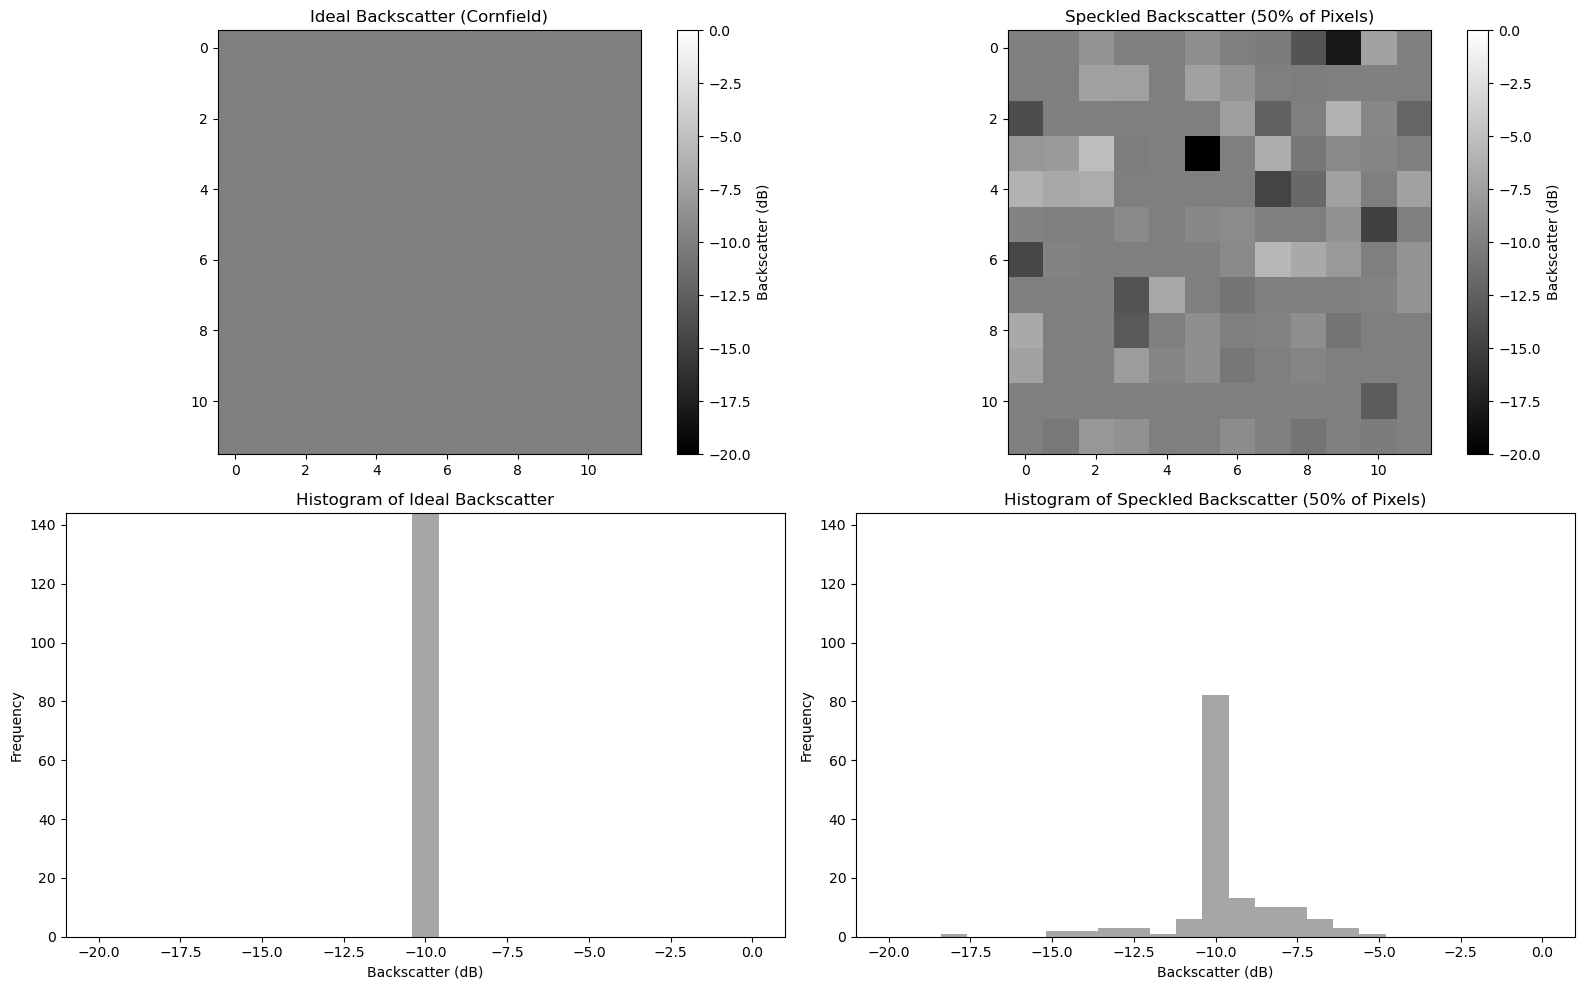

In [3]:
plt.figure(figsize=(16, 10))

# Ideal data
plt.subplot(2, 2, 1)
plt.imshow(ideal_data_dB, cmap='gray', vmin=-20, vmax=0)
plt.title("Ideal Backscatter (Cornfield)")
plt.colorbar(label='Backscatter (dB)')

# Speckled data
plt.subplot(2, 2, 2)
plt.imshow(speckled_data_dB, cmap='gray', vmin=-20, vmax=0)
plt.title(f"Speckled Backscatter ({int(speckle_fraction * 100)}% of Pixels)")
plt.colorbar(label='Backscatter (dB)')

bins = 25
hist_ideal, bins_ideal = np.histogram(ideal_data_dB.ravel(), bins=bins, range=(-20, 0))
hist_speckled, bins_speckled = np.histogram(speckled_data_dB.ravel(), bins=bins, range=(-20, 0))
max_freq = max(hist_ideal.max(), hist_speckled.max())  # maximum frequency for normalization

# Histogram for ideal data
plt.subplot(2, 2, 3)
plt.hist(ideal_data_dB.ravel(), bins=bins, range=(-20, 0), color='gray', alpha=0.7)
plt.ylim(0, max_freq)
plt.title("Histogram of Ideal Backscatter")
plt.xlabel('Backscatter (dB)')
plt.ylabel('Frequency')

# Histogram for speckled data
plt.subplot(2, 2, 4)
plt.hist(speckled_data_dB.ravel(), bins=bins, range=(-20, 0), color='gray', alpha=0.7)
plt.ylim(0, max_freq)
plt.title(f"Histogram of Speckled Backscatter ({int(speckle_fraction * 100)}% of Pixels)")
plt.xlabel('Backscatter (dB)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

What is interesting about this simulation is that we can imagine that second plot is **one pixel** of cornfield. In that case 30% of speckles would be objects that are not corn. Maybe we have harvested cornfield and those are rocks, some animals, some other vegetation, etc. Backscatter depends on:

- dielectric properties of an object,
- frequency of electromagnetic signal,
- angle of acqusition,
- cross section of ground object, etc.

That means that even if we take a SAR scene 10 seconds apart we can see different speckle pattern, because of wind for example. There are just many subpixel contributors that give us a complex scatter pattern. Actually, because of that we can say that speckle is Gaussian random noise - therefore we can remove it trough mean filtering or taking a scene over and over trough time!

## Neusidler See data

In [4]:
data_path = Path('~/shared/datasets/rs/datapool/mrs/Unit2-saocom_gamma/S1gammaNeusiedler').expanduser()

tif_files = glob(f"{data_path}/*.tif")

Now we can load the data and and apply preprocessing. Here we extract the scalingfactor and the date the image was taken from the metadata. We get a xarray.DataSet and convert it to an xarray.DataArray because we only have one variable, the VV backscatter.

In [5]:
def _preprocess(x):
    file = x.encoding['source']

    with rasterio.open(file) as src:
        scale_factor = pd.to_numeric(src.tags().get('scale_factor'))
        time_value = pd.to_datetime(src.tags().get('time_begin'))

        x = x / scale_factor
        x = x.assign_coords(time=time_value).expand_dims("time")

    return x.rename(
        {"band_data": "sig0"}
    ).squeeze("band").drop_vars("band")

sig0_ds_large = xr.open_mfdataset(
    '~/shared/datasets/rs/datapool/mrs/Unit2-saocom_gamma/S1gammaNeusiedler/*.tif',
    engine="rasterio",
    combine='nested',
    concat_dim="time",
    preprocess=_preprocess
)

sig0_ds_large = sig0_ds_large[list(sig0_ds_large.data_vars.keys())[0]]
sig0_ds_large

<xarray.DataArray 'sig0' (time: 8, y: 10000, x: 10000)> Size: 6GB
dask.array<concatenate, shape=(8, 10000, 10000), dtype=float64, chunksize=(1, 1, 10000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 80kB 5.2e+06 5.2e+06 5.2e+06 ... 5.3e+06 5.3e+06
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...

We will focus our attention to a smaller area containing a part of the Neusidlersee and its surrounding land.

/home/ljovic/miniconda3/envs/08_speckle-statistics/lib/python3.10/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


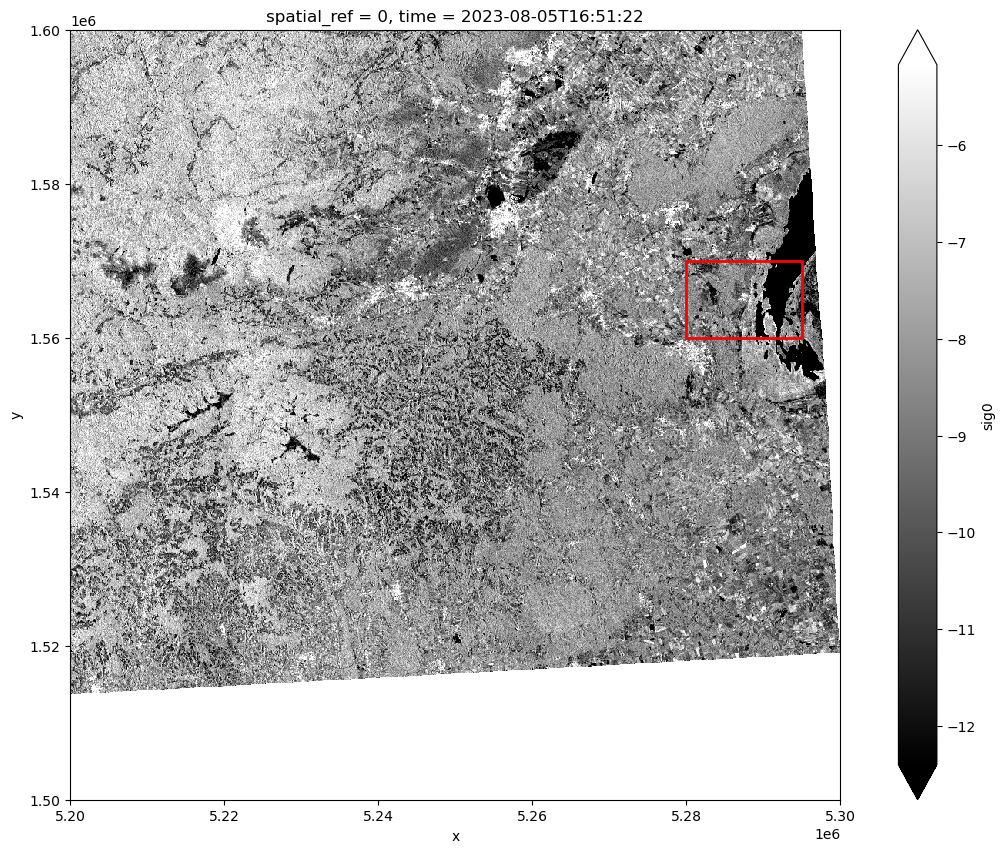

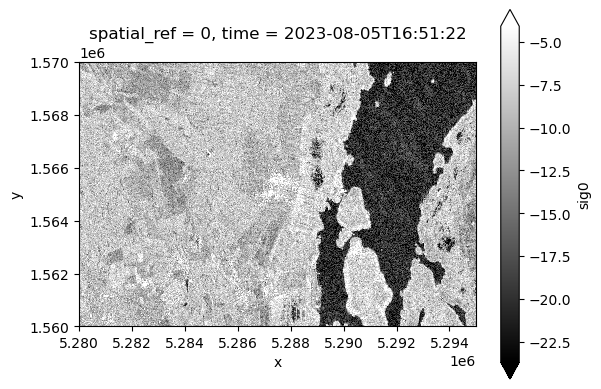

In [6]:
bounding_box = {
    'x_min': 5_280_000.0,
    'x_max': 5_295_000.0,
    'y_min': 1_560_000.0,
    'y_max': 1_570_000.0
}

img = sig0_ds_large.isel(time=0).coarsen(x=10, y=10, boundary='pad').median(skipna=True)

fig, ax = plt.subplots(figsize=(15, 10))
img.plot(ax=ax, robust=True, cmap="gray")

rect = mpatches.Rectangle(
    (bounding_box['x_min'], bounding_box['y_min']),
    bounding_box['x_max'] - bounding_box['x_min'],
    bounding_box['y_max'] - bounding_box['y_min'],
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)

ax.add_patch(rect)
ax.set_aspect('equal')
plt.show()

sig0_ds = sig0_ds_large.sel(x=slice(bounding_box['x_min'], bounding_box['x_max']), y=slice(bounding_box['y_max'], bounding_box['y_min']))
sig0_ds.isel(time=0).plot(cmap='gray', robust=True).axes.set_aspect('equal')

In [7]:
corine_path = Path('~/shared/datasets/rs/datapool/mrs/Corine_Land_Cover_2018.tif').expanduser()

corine_ds_large = (
    xr.open_dataset(corine_path, engine="rasterio")
    .rename({"band_data": "land_cover"})["land_cover"]
    .squeeze())
corine_ds_large

<xarray.DataArray 'land_cover' (y: 46000, x: 65000)> Size: 12GB
[2990000000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 520kB 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 368kB 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  136.429646247598
    STATISTICS_MAXIMUM:      48
    STATISTICS_MEAN:         25.753373398066
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.680310194836

We want to map both datasets to the same area.

Select area of interest
We convert the bounds of the large Sentinel 1 image (EPSG:27704) to the CRS of the corine dataset (EPSG:3035). Using this converted bounds we cut the Corine Dataset to a substantialy smaller size. If we do not cut it here already, the matching of the Corine and the Sentinel 1 dataset would take way longer. We do not want to use the smaller bounding box defined earlier for cutting, as this may lead to the loss of values in edge regions due to the nature of the coordinate systems.

In [8]:
transformer = Transformer.from_crs("EPSG:27704", "EPSG:3035", always_xy=True)

bbox_27704 = sig0_ds_large.rio.transform_bounds(sig0_ds_large.rio.crs)
bbox_3035 = transformer.transform_bounds(*bbox_27704)

x_min, y_min, x_max, y_max = bbox_3035
corine_ds = corine_ds_large.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))

corine_ds = corine_ds.rio.reproject_match(sig0_ds)

Colormapping and Encoding
For the different land cover types we use the official color encoding which can be found in CORINE Land Cover. The color mapping is stored in a json file under assets.

In [9]:
# Load encoding
with open('../assets/06_color_mapping.json', 'r') as f:
    color_mapping_data = json.load(f)

# Get mapping
color_mapping = {
    item['value']: item for item in color_mapping_data['land_cover']
    }

# Create cmap and norm for plotting
colors = [info['color'] for info in color_mapping.values()]
categories = [info['value'] for info in color_mapping.values()]
cmap = ListedColormap(colors)
norm = BoundaryNorm(categories + [max(categories) + 1], len(categories))

Now we merge the backscatter data (sig0_ds) with the land cover dataset (corine_ds) to have one dataset combining all data.

In [10]:
ds = xr.merge([sig0_ds, corine_ds]).drop_vars("band").compute()
ds

<xarray.Dataset> Size: 102MB
Dimensions:      (x: 1500, y: 1000, time: 8)
Coordinates:
  * x            (x) float64 12kB 5.28e+06 5.28e+06 ... 5.295e+06 5.295e+06
  * y            (y) float64 8kB 1.57e+06 1.57e+06 ... 1.56e+06 1.56e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...
Data variables:
    sig0         (time, y, x) float64 96MB -11.78 -11.47 ... -16.65 -16.03
    land_cover   (y, x) float32 6MB 12.0 12.0 12.0 12.0 ... 35.0 35.0 35.0 35.0

In [11]:
# Get landcover codes present in the image
present_landcover_codes = np.unique(corine_ds.values[~np.isnan(corine_ds.values)].astype(int))

Dashboard backscatter of different landcover over time

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
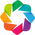

BokehModel(combine_events=True, render_bundle={'docs_json': {'5b388a83-7922-4ae2-9859-687c7fb1c572': {'version…

In [12]:
hv.extension('bokeh')

# ---------------

robust_min = ds.sig0.quantile(0.02).item()
robust_max = ds.sig0.quantile(0.98).item()

bin_edges = [
    i + j * 0.5
    for i in range(int(robust_min) - 2, int(robust_max) + 2)
    for j in range(2)
]

land_cover = {"\xa0\xa0\xa0 Complete Land Cover": 1}
land_cover.update({
    f"{int(value): 02} {color_mapping[value]['label']}": int(value)
    for value in present_landcover_codes
})
time = ds.sig0['time'].values

rangexy = RangeXY()

# ---------------


def load_image(time, land_cover, x_range, y_range):

    if land_cover == "\xa0\xa0\xa0 Complete Land Cover":
        sig0_selected_ds = ds.sig0.sel(time=time)

    else:
        land_cover_value = int(land_cover.split()[0])
        mask_ds = (ds.land_cover == land_cover_value)
        sig0_selected_ds = ds.sig0.sel(time=time).where(mask_ds)

    hv_ds = hv.Dataset(sig0_selected_ds)
    img = hv_ds.to(hv.Image, ["x", "y"])

    if x_range and y_range:
        img = img.select(x=x_range, y=y_range)
    return hv.Image(img).opts(
        cmap="gray", colorbar=True, frame_width=600, frame_height=600,
        tools=["hover"], clim=(robust_min, robust_max), aspect="equal")


dmap = hv.DynamicMap(
    load_image,
    kdims=["Time", "Landcover"],
    streams=[rangexy]
).redim.values(
    Time=time,
    Landcover=land_cover
).hist(
    normed=True,
    bins=bin_edges
    )

dmap = dmap.opts(framewise=True, show_title=True)
dmap

### Neusidler See

Now, lets work on real-life dataset to see how speckle actually looks like.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
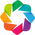

BokehModel(combine_events=True, render_bundle={'docs_json': {'c1c5682c-b9f8-479b-bf1e-f69cb8939288': {'version…

In [13]:
hv.extension('bokeh')

# ---------------

robust_min = ds.sig0.quantile(0.02).item()
robust_max = ds.sig0.quantile(0.98).item()

bin_edges = [
    i + j * 0.5
    for i in range(int(robust_min) - 2, int(robust_max) + 2)
    for j in range(2)
]

land_cover = {"\xa0\xa0\xa0 Complete Land Cover": 1}
land_cover.update({
    f"{int(value): 02} {color_mapping[value]['label']}": int(value)
    for value in present_landcover_codes
})
time = ds.sig0['time'].values

rangexy = RangeXY()

# ---------------


def load_image(time, land_cover, x_range, y_range):

    if land_cover == "\xa0\xa0\xa0 Complete Land Cover":
        sig0_selected_ds = ds.sig0.sel(time=time)

    else:
        land_cover_value = int(land_cover.split()[0])
        mask_ds = (ds.land_cover == land_cover_value)
        sig0_selected_ds = ds.sig0.sel(time=time).where(mask_ds)

    hv_ds = hv.Dataset(sig0_selected_ds)
    img = hv_ds.to(hv.Image, ["x", "y"])

    if x_range and y_range:
        img = img.select(x=x_range, y=y_range)
    return hv.Image(img).opts(
        cmap="gray", colorbar=True, frame_width=600, frame_height=600,
        tools=["hover"], clim=(robust_min, robust_max), aspect="equal")


dmap = hv.DynamicMap(
    load_image,
    kdims=["Time", "Landcover"],
    streams=[rangexy]
).redim.values(
    Time=time,
    Landcover=land_cover
).hist(
    normed=True,
    bins=bin_edges
    )

dmap = dmap.opts(framewise=True, show_title=True)
dmap

The speckle noise, also known as "salt-and-pepper" pattern, is visible. Also, what is important, we see Gaussian distribution of basckatter around expected value for each land cover. That means that distribution of noise has predictable random pattern, no matter the land cover or time instance. This follows Central Limit Theorem, where many independent processes tend to follow normal distribution.

From this, the conclusion is that we can average out noise and remove it trough either:
- spatial filtering - taking mean backscatter value over same land cover, or
- temporal filtering - focusing on small area or even one pixel, but averaging it over some time period.

Either way, one pixel is never representative of ground truth!

## Spatial filtering

In [14]:
def lee_filter(image, size=7):
    """
    Parameters:
    image (ndarray): 2D array representing the noisy image (e.g., radar image with speckle)
    size (int): Window size for the filter (must be odd, default is 7)

    Returns:
    filtered_image (ndarray): The filtered image with reduced speckle noise
    """

    # Mean and variance over local window
    mean_window = uniform_filter(image, size=size)
    mean_sq_window = uniform_filter(image ** 2, size=size)
    variance_window = mean_sq_window - mean_window ** 2

    # Noise variance estimation (this could also be set manually)
    overall_variance = np.var(image)

    # Compute the Lee filter
    weights = variance_window / (variance_window + overall_variance)
    filtered_image = mean_window + weights * (image - mean_window)

    return filtered_image


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
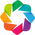

BokehModel(combine_events=True, render_bundle={'docs_json': {'54796daa-87a3-4322-b09f-4624a1b057f6': {'version…

In [15]:
hv.extension('bokeh')

robust_min = ds.sig0.quantile(0.02).item()
robust_max = ds.sig0.quantile(0.98).item()

bin_edges = [
    i + j * 0.5
    for i in range(int(robust_min) - 2, int(robust_max) + 2)
    for j in range(2)
]

land_cover = {"Complete Land Cover": 1}
land_cover.update({
    f"{int(value):02} {color_mapping[value]['label']}": int(value)
    for value in present_landcover_codes
})
time = ds.sig0['time'].values

rangexy = RangeXY()

# ---------------

def load_images(time, land_cover, x_range, y_range):
    """
    Returns a side-by-side plot of unfiltered and filtered images
    """
    if land_cover == "Complete Land Cover":
        sig0_selected_ds = ds.sig0.sel(time=time)
    else:
        land_cover_value = int(land_cover.split()[0])
        mask_ds = (ds.land_cover == land_cover_value)
        sig0_selected_ds = ds.sig0.sel(time=time).where(mask_ds)

    # Convert the data to a numpy array (assuming it's a DataArray)
    sig0_np = sig0_selected_ds.values
    
    # Apply the Lee filter to the selected data
    filtered_data = lee_filter(sig0_np, size=5)

    # Convert unfiltered data into Holoviews Image
    hv_ds_unfiltered = hv.Dataset((sig0_selected_ds['x'], sig0_selected_ds['y'], sig0_np), ['x', 'y'], 'sig0')
    unfiltered_img = hv_ds_unfiltered.to(hv.Image, ["x", "y"])

    # Convert filtered data into Holoviews Image
    hv_ds_filtered = hv.Dataset((sig0_selected_ds['x'], sig0_selected_ds['y'], filtered_data), ['x', 'y'], 'sig0')
    filtered_img = hv_ds_filtered.to(hv.Image, ["x", "y"])

    # Apply the range limits to the plots
    unfiltered_img = unfiltered_img.opts(
        cmap="gray", colorbar=True, frame_width=600, frame_height=600,
        tools=["hover"], clim=(robust_min, robust_max), aspect="equal", title="Unfiltered Image"
    )

    filtered_img = filtered_img.opts(
        cmap="gray", colorbar=True, frame_width=600, frame_height=600,
        tools=["hover"], clim=(robust_min, robust_max), aspect="equal", title="Filtered Image"
    )

    if x_range and y_range:
        unfiltered_img = unfiltered_img.select(x=x_range, y=y_range)
        filtered_img = filtered_img.select(x=x_range, y=y_range)

    # Return a side-by-side layout with unfiltered on the left and filtered on the right
    return unfiltered_img + filtered_img

dmap = hv.DynamicMap(
    load_images,
    kdims=["Time", "Landcover"],
    streams=[rangexy]
).redim.values(
    Time=time,
    Landcover=land_cover
)

dmap = dmap.opts(framewise=True, show_title=True)
dmap


## Temporal filtering

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
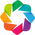

BokehModel(combine_events=True, render_bundle={'docs_json': {'c3f382ad-dcb5-44fd-a26b-3d2f6e7ffa9f': {'version…

In [16]:
hv.extension('bokeh')

robust_min = ds.sig0.quantile(0.02).item()
robust_max = ds.sig0.quantile(0.98).item()

bin_edges = [
    i + j * 0.5
    for i in range(int(robust_min) - 2, int(robust_max) + 2)
    for j in range(2)
]

land_cover = {"\xa0\xa0\xa0 Complete Land Cover": 1}
land_cover.update({
    f"{int(value): 02} {color_mapping[value]['label']}": int(value)
    for value in present_landcover_codes
})
time = ds.sig0['time'].values

rangexy = RangeXY()

# ---------------

def load_image(time, land_cover, x_range, y_range):
    if land_cover == "\xa0\xa0\xa0 Complete Land Cover":
        sig0_selected_ds = ds.sig0.sel(time=time)
    else:
        land_cover_value = int(land_cover.split()[0])
        mask_ds = (ds.land_cover == land_cover_value)
        sig0_selected_ds = ds.sig0.sel(time=time).where(mask_ds)

    hv_ds = hv.Dataset(sig0_selected_ds)
    img = hv_ds.to(hv.Image, ["x", "y"])

    if x_range and y_range:
        img = img.select(x=x_range, y=y_range)
    return hv.Image(img).opts(
        cmap="gray", colorbar=True, frame_width=600, frame_height=400,
        tools=["hover"], clim=(robust_min, robust_max), aspect="equal"
    )

# ---------------

# Function to dynamically load the mean image
def load_mean_image(x_range, y_range):
    sig0_mean = ds.sig0.mean(dim='time')
    hv_mean_ds = hv.Dataset(sig0_mean)
    mean_img = hv_mean_ds.to(hv.Image, ["x", "y"])
    
    if x_range and y_range:
        mean_img = mean_img.select(x=x_range, y=y_range)
        
    return hv.Image(mean_img).opts(
        cmap="gray", colorbar=True, frame_width=600, frame_height=400,
        tools=["hover"], clim=(robust_min, robust_max), aspect="equal"
    )

# ---------------

# DynamicMap for the temporal slices
dmap = hv.DynamicMap(
    load_image,
    kdims=["Time", "Landcover"],
    streams=[rangexy]
).redim.values(
    Time=time,
    Landcover=land_cover
).hist(
    normed=True,
    bins=bin_edges
).opts(framewise=True, show_title=True)


# DynamicMap for the mean image
mean_dmap = hv.DynamicMap(load_mean_image, streams=[rangexy]).hist(
    normed=True,
    bins=bin_edges
).opts(framewise=True)


layout = (dmap + mean_dmap).cols(1)
layout

Lets observe histograms of two plots. Especially in the region around lake, where histogram can be seen for water bodies and the rest of the area, it is clear that distribution is now less dispersed and more centered around central value.

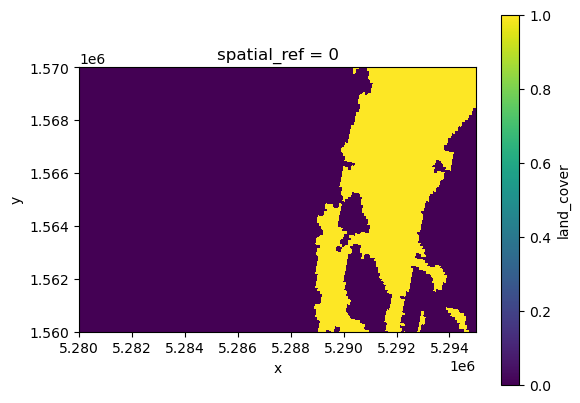

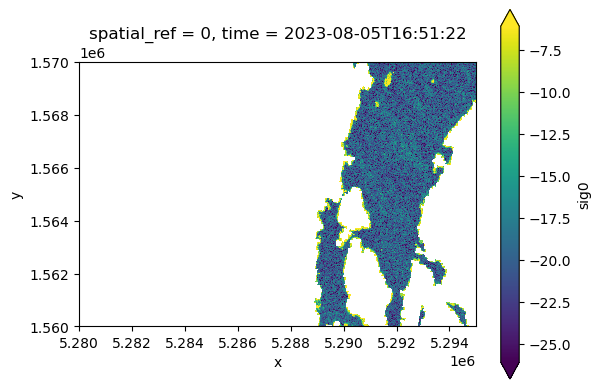

(array([4.0000e+00, 5.0000e+00, 8.0000e+00, 1.2000e+01, 2.6000e+01,
        6.8000e+01, 1.3500e+02, 2.7800e+02, 4.7400e+02, 8.9700e+02,
        1.6620e+03, 3.2390e+03, 6.0710e+03, 1.0679e+04, 1.6918e+04,
        2.4079e+04, 3.2191e+04, 4.0653e+04, 4.6097e+04, 4.4824e+04,
        3.6736e+04, 2.3587e+04, 1.1587e+04, 4.9570e+03, 2.3170e+03,
        1.6950e+03, 1.7260e+03, 2.1690e+03, 2.5250e+03, 3.0490e+03,
        3.3850e+03, 3.1900e+03, 2.8350e+03, 2.0030e+03, 1.2370e+03,
        5.7100e+02, 2.5000e+02, 8.8000e+01, 3.1000e+01, 2.9000e+01,
        2.0000e+01, 1.4000e+01, 1.2000e+01, 7.0000e+00, 1.0000e+01,
        8.0000e+00, 1.0000e+01, 5.0000e+00, 6.0000e+00, 4.0000e+00]),
 array([-37.91  , -36.9202, -35.9304, -34.9406, -33.9508, -32.961 ,
        -31.9712, -30.9814, -29.9916, -29.0018, -28.012 , -27.0222,
        -26.0324, -25.0426, -24.0528, -23.063 , -22.0732, -21.0834,
        -20.0936, -19.1038, -18.114 , -17.1242, -16.1344, -15.1446,
        -14.1548, -13.165 , -12.1752, -11.1854

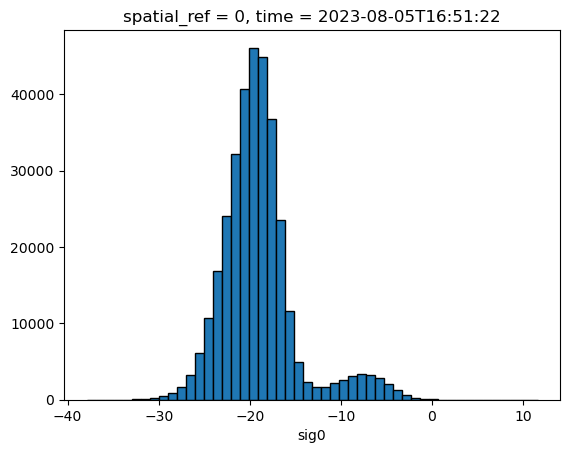

In [17]:
waterbodies_mask = (ds.land_cover == 41)  # 41 = encoded value for water bodies
waterbodies_mask.plot().axes.set_aspect('equal')

plt.show()
waterbodies_sig0 = ds.sig0.isel(time=0).where(waterbodies_mask)
waterbodies_sig0.plot(robust=True).axes.set_aspect('equal')

plt.show()
waterbodies_sig0.plot.hist(bins=50, edgecolor='black')